In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_ics = 1
n_odeparams = 1

#Times to evaluate the solution
times = np.arange(0.25,8,1)

#Instantiate the ODEModel
model_1 = ODEModel(odefunc = test_ode_func_1, 
                   y0 = 0,
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ics = n_ics,
                    n_odeparams = n_odeparams)

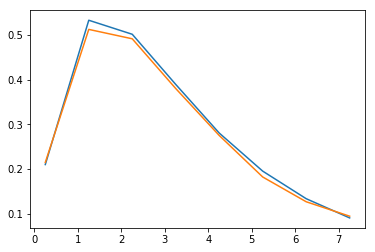

In [3]:
#Simulate the data and create data to learn from
sims, sens = model_1.simulate([0.4,0])


Y = scipy.stats.lognorm.rvs(s = 0.1, scale = sims)


plt.plot(times, sims)
plt.plot(times,Y)




In [ ]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model_1)

In [ ]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)
    y0 = pm.HalfNormal('y0',1)
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([alpha, y0],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(500, tune=500, init='adapt_diag', target_accept = 0.99)

pm.traceplot(trace)

plt.show()

all_params __str__ = [0.79788456 0.79788456]
ode_sol __str__ = [0.8533013  0.70173658 0.43278432 0.23784487 0.12290488 0.0611571
 0.02967723 0.01415011]
forward __str__ = [[-0.15864257]
 [-0.35419719]
 [-0.83751578]
 [-1.43613664]
 [-2.09634455]
 [-2.79430928]
 [-3.51737528]
 [-4.258033  ]]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, y0, alpha]
Sampling 2 chains:   3%|▎         | 68/2000 [00:29<29:24,  1.09draws/s]

In [ ]:
pm.posteriorplot.plot_posterior(trace);


In [ ]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

# Test 2: Scalar ODE with 2 Parameters

In [ ]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_ics = 1
n_odeparams = 2

#Times to evaluate the solution
times = np.arange(0.25,8,1)

#Instantiate the ODEModel
model_2 = ODEModel(odefunc = test_ode_func_2, 
                   y0 = 0,
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ics = n_ics,
                    n_odeparams = n_odeparams)

In [ ]:
f = augment_system(test_ode_func_2)